In [ ]:
! pip install kaggle
! pip install --upgrade --force-reinstall --no-deps kaggle # force install the latest version

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
comp = 'rsna-miccai-brain-tumor-radiogenomic-classification'
comp_dir = 'rsna-miccai'

# Download data to the working directory of my Colab instance. 
! kaggle competitions download -c {comp}
! unzip /content/{comp}.zip

In [ ]:
!pip install pydicom kornia opencv-python scikit-image nbdev fastai -U

In [7]:
from fastai.basics import *
#from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from tensorflow.keras import layers as nn, Sequential, Model, losses, metrics, optimizers
import tensorflow as tf
import glob
import pydicom
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [8]:
# PRINT IMAGES
path_='./train/00000'
med_data = glob.glob(path_ + f'/*')
imgs = {}

for folder in med_data:
  folder_names = folder.split('/')[-1]
  items = get_dicom_files(folder)
  img = [items[i].dcmread() for i in range(len(items))]
  imgs[folder_names] = img

images = []
for k in ['FLAIR', 'T1w', 'T1wCE', 'T2w']:
  print(f"{k} len: ", len(imgs[k]))
  images.append(imgs[k])

FLAIR len:  400
T1w len:  33
T1wCE len:  129
T2w len:  408


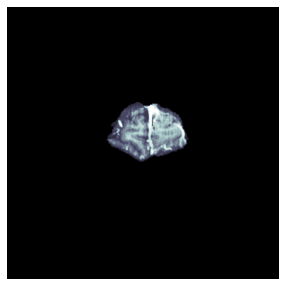

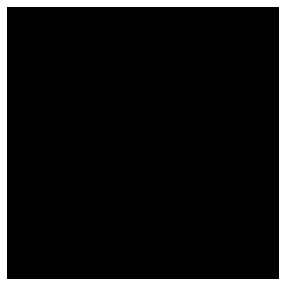

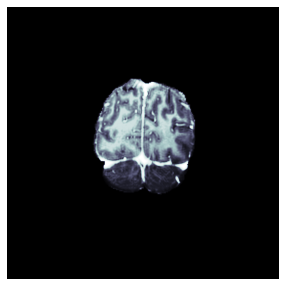

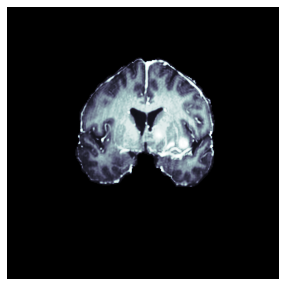

In [9]:
n = 5  # Change t
images[2][n].show()  #FOR FLAIR
images[2][2*n].show()  #FOR T1w
images[2][3*n].show()  #FOR T1wCE 
images[2][4*n].show()  #FOR T2w

Building the features and saving to file

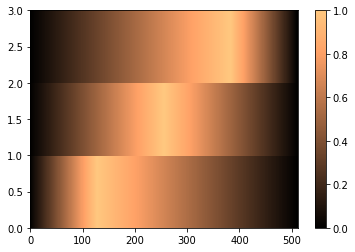

(512, 3)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
def get_features(inputs, rate, plot=False):
  size = inputs.shape[0]
  bp = int(size/4)
  mp = int(size/2)
  
  beg_points = np.concatenate((np.arange(bp),np.linspace(bp, 0, size-bp)), axis=0) 
  mid_points = np.concatenate((np.arange(mp),np.arange(int(size-mp), 0, -1)), axis=0) 
  end_points = beg_points[::-1]
  
  features_map = np.stack((beg_points, mid_points, end_points), axis=0) ** rate
  min_val = np.amin(features_map, axis=1, keepdims=True)
  max_val = np.amax(features_map, axis=1, keepdims=True)
  features_map = (features_map - min_val)/(max_val - min_val)

  if plot:
    plt.pcolormesh(features_map, cmap='copper')
    plt.colorbar()
    plt.show()
  return features_map.T


def process_ids(ids, rate=2., read_from_path='train', save_to_path=None):
  '''
  Only 'save_to_path' is not necessary
  '''
  ids_images = []
  for id_ in ids:
    zeros = ''.join('0'for _ in range(5-len(str(id_))))
    id_ = f'/{zeros}{id_}'
    read_from_path = './' + read_from_path + id_
    id_file = os.path.join(read_from_path,id_)
    med_data = glob.glob(id_path + f'/*')
 
    images = {}

    for folder in med_data:
      folder_names = folder.split('/')[-1]
      items = get_dicom_files(folder)
      img = [items[i].dcmread().pixel_array for i in range(len(items))]
      img = np.stack(img, axis=0).astype(np.float32) 
      img = img[np.where(np.sum(img, axis=(1,2)) > 0)] / 255
      feat = get_features(img, rate, plot=False)
      img = np.expand_dims(feat, axis=(2,3)) * np.expand_dims(img, axis=1)
      img = np.sum(img, axis=0)

      mean = np.mean(img, axis=0, keepdims=True) 
      img = np.concatenate((mean, img), axis=0)
      img = np.transpose(img, axes=(1,2,0))
      images[folder_names] = img
  
    images = [images[k]for k in ['FLAIR', 'T1w', 'T1wCE', 'T2w']]

    if save_to_path is not None:
      save_to_path = './' + save_to_path + id_
      id_file = os.path.join(save_to_path,id_)
      with open(id_file, "wb") as f:
        pickle.dump(images, f, pickle.HIGHEST_PROTOCOL)

    ids_images.append(images)
  return ids_images

def read_pickle_ids(ids, read_from_path='train'):
  ids_images = []

  for id_ in ids:
    zeros = ''.join('0'for _ in range(5-len(str(id_))))
    id_ = f'/{zeros}{id_}'
    read_from_path = './' + read_from_path + id_
    id_file = os.path.join(read_from_path,id_)

    if os.path.isfile(id_file):
      with open(id_file, 'rb') as f:
        images = pickle.load(f)
      ids_images.append(images)
    else:
      print(f'File {id_file} does not exist')
      continue
  return ids_images

fm = get_features(np.ones((512)), rate=1, plot=True)
fm.shape

In [ ]:
img = np.ones((36,512,512))
feat = np.ones((36,3))

img = np.expand_dims(feat, axis=(2,3)) * np.expand_dims(img, axis=1)
img.shape


(36, 3, 512, 512)

(512, 512)


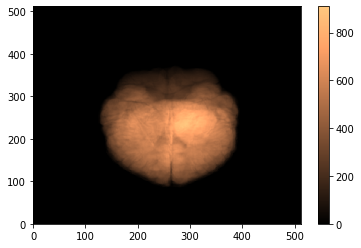

In [ ]:
FLAIR = [images[0][i].pixel_array for i in range(len(images[0]))]
FLAIR = np.stack(FLAIR, axis=0)
mean = np.mean(FLAIR, axis=0)
print(mean.shape)
plt.pcolormesh(mean, cmap='copper')
plt.colorbar()
plt.show()

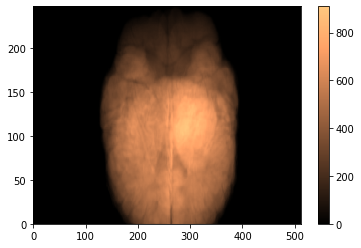

In [ ]:
n = mean[np.where(np.sum(mean, axis=0) > 1e2)]
n = n[np.where(np.sum(n, axis=1) > 1e2)]
plt.pcolormesh(n, cmap='copper')
plt.colorbar()
plt.show()

In [ ]:
def read_example(path_='./train/00000'):
  med_data = glob.glob(path_ + f'/*')
  images = {}

  for folder in med_data:
    folder_names = folder.split('/')[-1]
    items = get_dicom_files(folder)
    img = [items[i].dcmread().pixel_array for i in range(len(items))]
    img = np.stack(img, axis=0)

    img = img[np.where(np.sum(img, axis=(1,2)) > 0)]
    mean = np.mean(img, axis=0, keepdims=True) / 255
    
    img = np.expand_dims(img, axis=-1)
    images[folder_names] = img
  
  images = [images[k]for k in ['FLAIR', 'T1w', 'T1wCE', 'T2w']]
  return images

def read_batch(batch_ids, folder='train'):
  batch = []
  for id_ in batch_ids:
    zeros = ''.join('0'for _ in range(5-len(str(id_))))
    batch.append(read_example(path_= './' + folder + f'/{zeros}{id_}'))

  return batch

In [ ]:
images = read_example('./train/00002')

# Nova seção

In [ ]:
df = pd.read_csv("train_labels.csv")
df.head()

ids = df['BraTS21ID']
train_size = 0.75
train_ids = df[['BraTS21ID', 'MGMT_value']].sample(int(train_size * df.shape[0]))
test_ids = df[~df['BraTS21ID'].isin(train_ids['BraTS21ID'])]

train_ids.shape[0], test_ids.shape[0]

(438, 147)

In [ ]:
class AttentionEncoder(nn.Layer):
  def __init__(self, key_dim, num_heads, dff, activation, name, center, rate=0.1, **kwargs):
    super(AttentionEncoder, self).__init__(name=name)

    self.mha = nn.MultiHeadAttention(num_heads, key_dim, name="mha")

    self.dense1 = nn.Dense(dff, activation=activation, name="dense1") # (batch_size, seq_len, dff)self.dense2 = nn.Dense(key_dim, kernel_initializer=get_initializer(), name="dense2") # (batch_size, seq_len, key_dim)
    self.dense2 = nn.Dense(key_dim, activation=activation, name="dense2")

    self.layernorm1 = nn.LayerNormalization(epsilon=1e-6, center=center, name="layernorm1")
    self.layernorm2 = nn.LayerNormalization(epsilon=1e-6, center=center, name="layernorm2")

    self.dropout1 = nn.Dropout(rate, name="dropout1")
    self.dropout2 = nn.Dropout(rate, name="dropout2")

  def call(self, X, Y, mask, training=True): #
    attn_output = self.mha(
        query= X,
        value= Y,
        key= Y,
        attention_mask=mask,
        return_attention_scores = False) 

    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(X + attn_output) 

    ffn_output = self.dense1(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    ffn_output = self.dense2(ffn_output) 
    out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, key_dim)
    return out2

In [ ]:
class SetAttention(nn.Layer):
  def __init__(self, input_shape, dff=36, num_heads=2, activation='relu', name="SetAttention", **kwargs):
    super(SetAttention, self).__init__(name=name)
    self.in_dim = input_shape[-1]
    self.latent_size = 10

    self.imha = AttentionEncoder(self.in_dim, num_heads=2*num_heads, dff=dff, activation=activation, center=True, name="imha")
    self.xmha = AttentionEncoder(self.in_dim, num_heads=num_heads, dff=dff, activation=activation, center=True, name="xmha")
    self.inducing_points = tf.Variable(tf.random_normal_initializer(seed=0)(shape=[self.latent_size, self.in_dim]), dtype=tf.float32, name="inducing_points", trainable=True)

  def call(self, inputs):
    #inputs = tf.expand_dims(inputs, axis=0)
    ip = tf.repeat(tf.expand_dims(self.inducing_points, axis=0), inputs.shape[0], axis=0)
    H = self.imha(X=ip, Y=inputs, mask=None)
    x = self.xmha(X=H, Y=H, mask=None)
    return x

In [ ]:
class RSNAModel(Model):
  def __init__(self, folder_number=4, conv_kernel=9, strides=2, dff=36, num_heads=2, activation=tf.nn.leaky_relu, name="Kaggle", **kwargs):
    super(RSNAModel, self).__init__(name=name)
    self.folder_number = folder_number

    self.features = Sequential([
      nn.MaxPool2D(2),
      nn.Conv2D(64, conv_kernel, strides=1, activation=activation),
      nn.MaxPool2D(2),
      nn.Conv2D(64, conv_kernel, strides=1, activation=activation),
      nn.Conv2D(16, conv_kernel, strides=strides, activation=activation)
    ])


    # self.branches = [Sequential([
    # nn.Flatten(),
    # nn.Dense(18, activation=activation),
    # SetAttention(input_shape=(18,), dff=dff, num_heads=num_heads)
    # ])for _ in range(folder_number)]

    self.Attention = Sequential([
      nn.Dense(18, activation=activation),
      SetAttention(input_shape=(18,), dff=dff, num_heads=num_heads)
    ])
    

    self.labels = Sequential([
                              nn.Dense(64, activation=activation),
                              nn.Dense(32, activation=activation),
                              nn.Flatten(),
                              nn.Dense(2, activation='softmax')
    ])


  def call(self, inputs): #conv inputs.shape = (n, 256, 256, 1) 
    x = []
    for i in range(self.folder_number):
      x.append(tf.image.resize(inputs[i], (256,256)))
    x = tf.concat(x, axis=0)
    x = self.features(x)
    #output = tf.concat(outputs, axis=0)
    x = tf.reshape(x, (x.shape[0],-1,x.shape[-1]))
    x = self.Attention(x)
    output = tf.reshape(output, (1, -1))
    output = self.labels(output)
    return output

In [ ]:
from time import time
loss_fn = losses.CategoricalCrossentropy()
learning_rate = 5e-3
optimizer = optimizers.Adam(learning_rate = 5e-3)

@tf.autograph.experimental.do_not_convert
def update_model(model, data, labels):
  """
  data should be a list of examples (e.g. patients 00000, 00002 ... from training set)
  labels should be a 2D vector of shape = (num_examples, num_classes=2), each label must be of size (1,2), that is [[1., 0.]] if healthy and [[0., 1.]] if not
  """
  labels = tf.cast(labels, tf.float32)
  with tf.GradientTape() as tape:
    probabilities = tf.concat([model(d) for d in data], axis=0)
    #print(probabilities)
    loss = loss_fn(labels, probabilities)

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss, probabilities


AUC = metrics.AUC(curve="ROC", name="AUC", dtype="float32")
accuracy = metrics.BinaryAccuracy(dtype="float32")
def evaluate(labels, predicted):
    accuracy.reset_states()
    accuracy.update_state(labels, predicted, sample_weight=1)
    acc = accuracy.result().numpy()

    AUC.reset_states()
    AUC.update_state(labels, predicted, sample_weight=1)
    auc = AUC.result().numpy()
    return acc, auc

def train(model, train_ids, test_ids=None, batch_size=1, epochs=200, warmup_epochs=10, validation_steps=10, patience=5, debug=True):

  batches_idx = [(i, min(i+batch_size,train_ids.shape[0])) for i in range(0, train_ids.shape[0], batch_size)]
  test_b_idx = [(i, min(i+batch_size,test_ids.shape[0])) for i in range(0, test_ids.shape[0], batch_size)]

  max_acc = 0
  patience_cnt = 0

  for e in range(epochs):
    losses = []
    accuracies = []
    aucs = []

    ti = time()
    for bi, be in batches_idx:
      ids = train_ids[bi:be]
      d = read_batch(list(ids['BraTS21ID']))
      lbs = tf.one_hot(ids['MGMT_value'].to_numpy(), depth=2)
      # d = data[bi:be]
      # lbs = labels[bi:be]
      loss, probs = update_model(model, d, lbs)

      acc, auc = evaluate(lbs, probs)
      print(f"Epoch {e+1} -> loss: {loss} | acc: {acc} | auc: {auc} | probs: {probs.numpy()}")
      losses.append(loss)
      accuracies.append(acc)
      aucs.append(auc)
    ti = time() - ti

    model.save_weights('rsnamodel.h5')
    if e + 1 >= warmup_epochs and (e+1) % validation_steps == 0. and test_ids is not None:
      ti = time()
      test_data = read_batch(list(test_ids['BraTS21ID']))
      test_labels = tf.one_hot(test_ids['MGMT_value'].to_numpy(), depth=2)
      test_probs = tf.concat([model(test_d) for test_d in test_data], axis=0)
      t_acc, t_auc = evaluate(test_labels, test_probs)
      ti = time() - ti
      if debug: print(f"Test data evaluation -> acc: {t_acc} | auc: {t_auc} | runtime: {ti}")

      if t_acc <= max_acc:
          patience_cnt += 1
          if debug: print(f'Patience: {patience_cnt}/{patience}')
          if patience_cnt >= patience:
              if debug: print('Reached max patience. Stopping training.')
              break
      else:
          patience_cnt = 0

      max_acc = max(max_acc, t_acc)
  return model

In [ ]:
model = RSNAModel()

In [ ]:
model = train(model, train_ids, test_ids)